In [2]:
import numpy as np
import cv2
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt




# frame 이미지 자르기

In [ ]:
# os.chdir('/content/drive/My Drive/LaneDetection')

In [13]:
cap= cv2.VideoCapture('assets/original_vid.mp4')
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite('frames/frame_'+str(i)+'.jpg', frame)
    i+=1
 
cap.release()
cv2.destroyAllWindows()

# Perspective transformation to a bird’s eye view

In [3]:
img = np.array(mpimg.imread('frames/frame_1250.jpg'))


img[460:470, 590:600] = 255 # upper left
img[650:660, 380:390 ] = 255 # lower left
img[460:470, 730:740] = 255 # upper right
img[650:660, 1110:1120 ] = 125 # lower right
plt.imshow(img)
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'frames/frame_1250.jpg'

In [44]:
src = np.array([
                [595, 465],
                [385, 655],
                [735, 465],
                [1115, 655]
], dtype=np.float32)

target = np.array([
                [595, 0],
                [595, 655],
                [1000, 0],
                [1000, 655]
], dtype=np.float32)




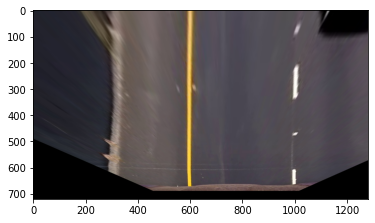

In [80]:
def warp(img, src, target):
    try:
        y, x, c = img.shape
    except:
        y, x = img.shape # gray image color channel none  
    M= cv2.getPerspectiveTransform(src, target) # 변환 행렬
    warped = cv2.warpPerspective(img, M, (x, y), flags=cv2.INTER_LINEAR)
    return warped    

img = np.array(mpimg.imread('frames/frame_1250.jpg'))

warped = warp(img, src, target)
plt.imshow(warped)
plt.show()



# Filtering


## Region Of Interest

In [84]:
def region_of_interest(img, vertices=None):
    imshape= img.shape
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    if vertices is None:
        vertices = np.array([
            [(100, img_h), (1200, img_h), (img_w / 2, img_h / 2)]
        ], dtype=np.int32)
        
    #draw_lines(img,[[(0,imshape[0],imshape[1]//2 - 20, 3*imshape[0]//5),(imshape[1]//2 - 20, 3*imshape[0]//5,imshape[1]//2 + 20, 3*imshape[0]//5),(imshape[1]//2 + 20, 3*imshape[0]//5,imshape[1],imshape[0]), (imshape[1],imshape[0],0,imshape[0])]] )
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

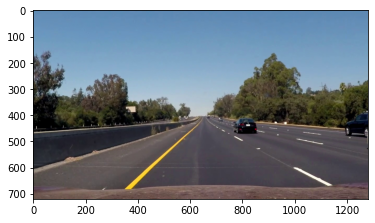

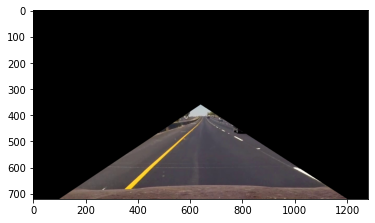

In [85]:
img = np.array(mpimg.imread('frames/frame_1250.jpg'))

masked_img = region_of_interest(img)
plt.imshow(img)
plt.show()
plt.imshow(masked_img)
plt.show()


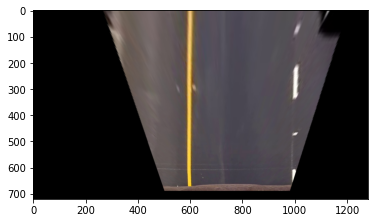

In [86]:
warped_masked_img = warp(masked_img, src, target)
plt.imshow(warped_masked_img)
plt.show()

In [93]:
def filter(img):
    img = np.copy(img)
    # gray로 변환을 하기 때문에 img parameter는 3개의 채널을 갖는 이미지
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 노이즈 제거 위한 가우시안 블러 진행
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    
    # canny edge detection
    canny_min = 50
    canny_max = 150
    canny = cv2.Canny(blur, canny_min, canny_max)

    return canny
    


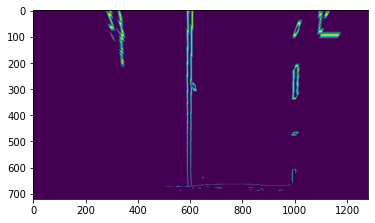

In [94]:
filtered = filter(img)

roi_img = region_of_interest(filtered)
warped = warp(roi_img, src, target)

plt.imshow(warped)
plt.show()

# Lane finding with histogram and sliding window


## fitWindow function

In [114]:
def fitWindow(binary, x, binary_viz, left_current, right_current, left_delta, right_delta, windowWidth=150, windowHeight=90, thresh=35):
    binary_viz = binary_viz.copy()
    overlapU = windowHeight//2
    overlapD = windowHeight//2
    s = windowWidth//2

    # x 만큼 위에 슬라이딩 윈도우 그린다.
    left_win = binary[720 - windowHeight*(x+1) - overlapU :720 - windowHeight*x + overlapD, left_current - s: left_current + s]
    right_win = binary[720 - windowHeight*(x+1) - overlapU: 720 - windowHeight*x + overlapD, right_current - s: right_current + s]
    # 윈도우 밖은 관심이 없기 때문에 지워준다.

    # red channel
    binary_viz[720 - windowHeight*(x+1): 720-windowHeight*x, left_current - s: left_current + s, 1:] = 0
    # 윈도우 가운데 점
    binary_viz[720 - windowHeight*(x+1) + 40: 720-windowHeight*x - 40, left_current - 5: left_current + 5, 0] = 255

    # blue channel
    binary_viz[720 - windowHeight*(x+1): 720-windowHeight*x, right_current -s: right_current + s, :-1] = 0
    # 윈도우 가운데 점
    binary_viz[720 - windowHeight*(x+1) + 40:720-windowHeight*x-40, right_current - 5: right_current + 5, -1] = 255 

    # green channel은 지우지 않음.
    binary_viz[720 - windowHeight*(x+1):720-windowHeight*x, :left_current - s] = 0
    binary_viz[720 - windowHeight*(x+1):720-windowHeight*x, left_current + s: right_current - s] = 0
    binary_viz[720 - windowHeight*(x+1):720-windowHeight*x, right_current + s:] = 0

    
    # green channel에 대해서 상자를 그린다.
    binary_viz[720 - windowHeight*(x+1): 720-windowHeight*x, left_current - s - 5: left_current - s + 5] = np.array([0, 255, 0])
    binary_viz[720 - windowHeight*(x+1): 720-windowHeight*x, left_current + s - 5: left_current + s + 5] = np.array([0, 255, 0])
    binary_viz[720 - windowHeight*(x) - 10:720-windowHeight*x, left_current - s: left_current + s] = np.array([0, 255, 0])
    binary_viz[720 - windowHeight*(x+1) - 10:720-windowHeight*(x+1)+10, left_current - s: left_current + s] = np.array([0, 255, 0])
    
    binary_viz[720 - windowHeight*(x+1):720-windowHeight*x, right_current - s - 5: right_current - s + 5] = np.array([0, 255, 0])
    binary_viz[720 - windowHeight*(x+1):720-windowHeight*x, right_current + s - 5: right_current + s + 5] = np.array([0, 255, 0])
    binary_viz[720 - windowHeight*(x) - 10:720-windowHeight*x, right_current - s: right_current + s] = np.array([0, 255, 0])
    binary_viz[720 - windowHeight*(x+1) - 10:720-windowHeight*(x+1)+10, right_current - s: right_current + s] = np.array([0, 255, 0])

    # 움직인 양만큼 보정해준다.
    try:
        # sum 값이 thresh 와 비교
        if np.max(np.sum(left_win, axis=0)) > thresh:
            left_delta = np.argmax(np.sum(left_win, axis=0)) - s
        # elif np.max(np.sum(right_win, axis=0)) > thresh:
            #left_delta = np.argmax(np.sum(right_win, axis=0))-s
            # ...
    except:
        ...
        

    try:
        if np.max(np.sum(right_win, axis=0)) > thresh:
            right_delta = np.argmax(np.sum(right_win, axis=0)) - s
            
        # elif np.max(np.sum(left_win, axis=0)) > thresh:
        #     ...
            # right_delta = np.argmax(np.sum(left_win, axis=0)) - s
            
    except:
        ...
        
    # 변화량에 대해서 현재 위치를 변화시켜준다.
    left_current += left_delta
    # print(f"left_current: {left_current}")
    right_current += right_delta
    # print(f"right_current: {right_current}")
    
    

    return binary_viz, left_current, right_current, left_delta, right_delta


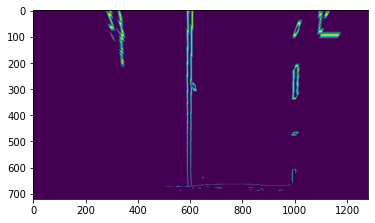

In [96]:
filtered = filter(img)

roi_img = region_of_interest(filtered)
image = warp(roi_img, src, target)

plt.imshow(image)
plt.show()

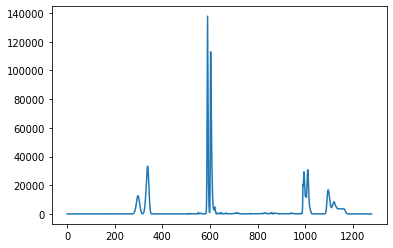

In [98]:

hist = np.sum(image, axis=0)
plt.plot(hist)
plt.show()

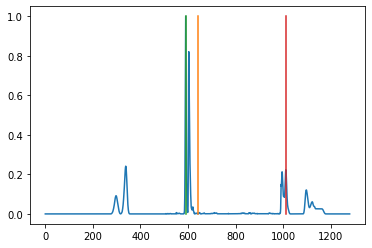

In [107]:

hist = np.sum(image, axis=0)
plt.plot(hist / hist.max())

plt.plot([640, 640], [0, 1]) # center

leftx_base = np.argmax(hist[:640])
rightx_base = np.argmax(hist[640:]) + 640

plt.plot([leftx_base, leftx_base], [0, 1]) # left line
plt.plot([rightx_base, rightx_base], [0, 1]) # right line
plt.show()


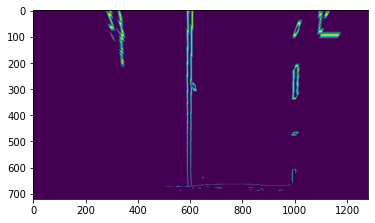

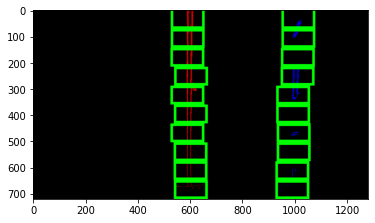

In [115]:
binary_viz = np.dstack((image, image, image))

windowWidth = 120
windowHeight = 72

left_current = leftx_base
right_current = rightx_base

left_delta = 0
right_delta = 0

# 10개의 슬라이딩 윈도우 작성
for x in range(720//windowHeight):
    # 2번의 fitWindow 과정 존재. 보정을 위해 다시 그립니다.
    _, left_current, right_current, left_delta, right_delta = \
        fitWindow(image, x, binary_viz, left_current, right_current, left_delta, right_delta, \
                  windowWidth=windowWidth, windowHeight=windowHeight, thresh=10)
    binary_viz, left_current, right_current, left_delta, right_delta = \
        fitWindow(image, x, binary_viz, left_current, right_current, left_delta, right_delta, \
                  windowWidth=windowWidth, windowHeight=windowHeight, thresh=10)

plt.imshow(image)
plt.show()
plt.imshow(binary_viz)
plt.show()
    

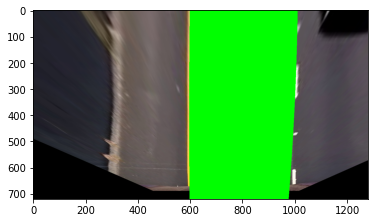

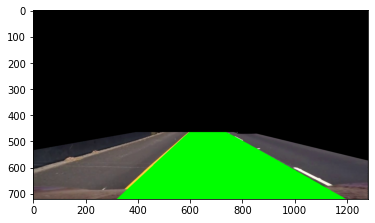

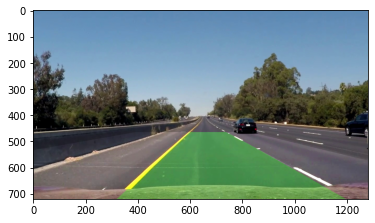

In [126]:

left_idx = binary_viz[:,:,0].nonzero()
right_idx = binary_viz[:,:,2].nonzero()

left_fit = np.polyfit(left_idx[0], left_idx[1], 2)
right_fit = np.polyfit(right_idx[0], right_idx[1], 2)



ploty = np.arange(0, 720)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

warped_img = warp(img, src, target)
overlay = warped_img.copy()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(overlay, np.int_([pts]), (0,255, 0))

plt.imshow(overlay)
plt.show()

newwarp = warp(overlay, target, src)
plt.imshow(newwarp)
plt.show()

result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()

# Detect Lane

In [131]:
def detect_lane(img, src, target):
    '''
    1. filter
    2. roi
    3. warp
    4. 
    '''
    filtered = filter(img)
    roi_img = region_of_interest(filtered)
    image = warp(roi_img, src, target)

    hist = np.sum(image, axis=0)

    leftx_base = np.argmax(hist[:640])
    rightx_base = np.argmax(hist[640:]) + 640

    binary_viz = np.dstack((image, image, image))

    windowWidth = 120
    windowHeight = 72

    left_current = leftx_base
    right_current = rightx_base

    left_delta = 0
    right_delta = 0

    # 10개의 슬라이딩 윈도우 작성
    for x in range(720//windowHeight):
        # 2번의 fitWindow 과정 존재. 보정을 위해 다시 그립니다.
        _, left_current, right_current, left_delta, right_delta = \
            fitWindow(image, x, binary_viz, left_current, right_current, left_delta, right_delta, \
                      windowWidth=windowWidth, windowHeight=windowHeight, thresh=10)
        binary_viz, left_current, right_current, left_delta, right_delta = \
            fitWindow(image, x, binary_viz, left_current, right_current, left_delta, right_delta, \
                      windowWidth=windowWidth, windowHeight=windowHeight, thresh=10)

    left_idx = binary_viz[:,:,0].nonzero()
    right_idx = binary_viz[:,:,2].nonzero()

    left_fit = np.polyfit(left_idx[0], left_idx[1], 2)
    right_fit = np.polyfit(right_idx[0], right_idx[1], 2)


    ploty = np.arange(0, 720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warped_img = warp(img, src, target)
    overlay = warped_img.copy()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(overlay, np.int_([pts]), (0,255, 0))

    newwarp = warp(overlay, target, src)

    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    # plt.imshow(result)
    # plt.show()
    return result

In [155]:
src = np.array([
                [595, 465],
                [385, 655],
                [735, 465],
                [1115, 655]
], dtype=np.float32)

target = np.array([
                [595, 0],
                [595, 655],
                [1000, 0],
                [1000, 655]
], dtype=np.float32)


# range(0, 1259)
for i in range(0, 1259):
    img = np.array(mpimg.imread(f'frames/frame_{i}.jpg'))
    print(f'frames/frame_{i}.jpg')
    try:
        result_image = detect_lane(img, src, target)
        cv2.imwrite(f'result/result_{i}.jpg',result_image)
    except:
      print(f'{i}.jpg is wrong....')
    


frames/frame_0.jpg
frames/frame_1.jpg
frames/frame_2.jpg
frames/frame_3.jpg
frames/frame_4.jpg
frames/frame_5.jpg
frames/frame_6.jpg
frames/frame_7.jpg
frames/frame_8.jpg
frames/frame_9.jpg
frames/frame_10.jpg
frames/frame_11.jpg
frames/frame_12.jpg
frames/frame_13.jpg
frames/frame_14.jpg
frames/frame_15.jpg
frames/frame_16.jpg
frames/frame_17.jpg
frames/frame_18.jpg
frames/frame_19.jpg
frames/frame_20.jpg
frames/frame_21.jpg
frames/frame_22.jpg
frames/frame_23.jpg
frames/frame_24.jpg
frames/frame_25.jpg
frames/frame_26.jpg
frames/frame_27.jpg
frames/frame_28.jpg
frames/frame_29.jpg
frames/frame_30.jpg
frames/frame_31.jpg
frames/frame_32.jpg
frames/frame_33.jpg
frames/frame_34.jpg
frames/frame_35.jpg
frames/frame_36.jpg
frames/frame_37.jpg
frames/frame_38.jpg
frames/frame_39.jpg
frames/frame_40.jpg
frames/frame_41.jpg
frames/frame_42.jpg
frames/frame_43.jpg
frames/frame_44.jpg
frames/frame_45.jpg
frames/frame_46.jpg
frames/frame_47.jpg
frames/frame_48.jpg
frames/frame_49.jpg
frames/fra

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RankWarning: Polyfit may be poorly conditioned


frames/frame_755.jpg
frames/frame_756.jpg
frames/frame_757.jpg
757.jpg is wrong....
frames/frame_758.jpg
758.jpg is wrong....
frames/frame_759.jpg
759.jpg is wrong....
frames/frame_760.jpg
760.jpg is wrong....
frames/frame_761.jpg
761.jpg is wrong....
frames/frame_762.jpg
762.jpg is wrong....
frames/frame_763.jpg
763.jpg is wrong....
frames/frame_764.jpg
764.jpg is wrong....
frames/frame_765.jpg
765.jpg is wrong....
frames/frame_766.jpg
766.jpg is wrong....
frames/frame_767.jpg
767.jpg is wrong....
frames/frame_768.jpg
768.jpg is wrong....
frames/frame_769.jpg
769.jpg is wrong....
frames/frame_770.jpg
770.jpg is wrong....
frames/frame_771.jpg
771.jpg is wrong....
frames/frame_772.jpg
772.jpg is wrong....
frames/frame_773.jpg
773.jpg is wrong....
frames/frame_774.jpg
774.jpg is wrong....
frames/frame_775.jpg
775.jpg is wrong....
frames/frame_776.jpg
776.jpg is wrong....
frames/frame_777.jpg
frames/frame_778.jpg
frames/frame_779.jpg
frames/frame_780.jpg
frames/frame_781.jpg
frames/frame_

In [156]:
def img2mp4(paths, pathOut , fps =10 ):
    frame_array = []
    for idx , path in enumerate(paths): 
        try:
            print(path)
            img = cv2.imread(os.path.join(path))
            
            height, width, layers = img.shape
            size = (width,height)
            frame_array.append(img)
        except:
            continue
    
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

paths = sorted(os.listdir('result/'))
paths = [os.path.join('result/result_' + str(idx) + ".jpg" ) for idx in range(0, 1259)]


img2mp4(paths , './result.mp4', fps=20)

result/result_0.jpg
result/result_1.jpg
result/result_2.jpg
result/result_3.jpg
result/result_4.jpg
result/result_5.jpg
result/result_6.jpg
result/result_7.jpg
result/result_8.jpg
result/result_9.jpg
result/result_10.jpg
result/result_11.jpg
result/result_12.jpg
result/result_13.jpg
result/result_14.jpg
result/result_15.jpg
result/result_16.jpg
result/result_17.jpg
result/result_18.jpg
result/result_19.jpg
result/result_20.jpg
result/result_21.jpg
result/result_22.jpg
result/result_23.jpg
result/result_24.jpg
result/result_25.jpg
result/result_26.jpg
result/result_27.jpg
result/result_28.jpg
result/result_29.jpg
result/result_30.jpg
result/result_31.jpg
result/result_32.jpg
result/result_33.jpg
result/result_34.jpg
result/result_35.jpg
result/result_36.jpg
result/result_37.jpg
result/result_38.jpg
result/result_39.jpg
result/result_40.jpg
result/result_41.jpg
result/result_42.jpg
result/result_43.jpg
result/result_44.jpg
result/result_45.jpg
result/result_46.jpg
result/result_47.jpg
re

In [150]:
!ls

assets	frames	result
